<a href="https://colab.research.google.com/github/TUIlmenauAMS/AES_Tutorial_2018_FiltersForAudio/blob/main/filtersForAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Tutorial T04
# Digital Filters, Filter Banks and Their Design for Audio Applications
## With Python Examples

### Gerald Schuller 
### Ilmenau University of Technology and Fraunhofer Institute of Media Technology, Germany

<p style="line-height:1.5">
    
## Linear Filters, Convolution

Examples of linear filters: low pass filters, band pass filters

**Linearity:**

<style>
line-height: 160%;
</style> 
    
-  Same result if we **add** two signals before or after the filter

-  Same result if we apply **gain or attenuation** before or after the filter


A digital audio signal can be seen as a **sum of its samples** $x(n)$.

Each sample of a signal can be seen as an impulse of the sample value, producing the filters "Impulse Response" $h(n)$ multiplied by the sample value.

Hence the sum of all samples at the filter input results in the "**convolution**" of the signal $x(n)$ with the
filter impulse response as output $y(n)$,

$$y(n)= \sum_{m}^{L-1} x(n-m) \cdot h(m) = x(n) * h(n) $$

"$*$" is a short notation for convolution.

We see: from **earlier signal samples later impulse response samples** are added.

Observe: In effect this is a **sliding weighted sum of past samples**.

In Python this is implemented in the function `scipy.signal.lfilter`.

## The z-Transform

-  If these samples where coefficients of polynomials, then this convolution sum would be the result of the multiplication of the polynomials. 
-  This leads to the "**z-Transform**", which converts samples $x(n)$ into polynomials $X(z)$

$$X(z)= \sum_{n=0}^\infty x(n) \cdot z^{-n}$$

-  The **convolution** in the time domain then turns into a **multiplication** in the z-domain, 
-  This is an important and convenient simplification for **filter design and analysis**,
$$x(n)*h(n) \rightarrow X(z) \cdot H(z)$$
-  Imagine the z-domain as a **generalized frequency domain**.
-  The usual frequency domain with normalized frequency $\omega$ (with $\pi$ corresponding to the Nyquist frequency) is obtained by setting 
$$ z= e^{j \omega}$$

## Example Application: Lowpass Filtering for Sampling Rate Change

-  If we want to reduce the sampling rate of an audio signal, we first need to lowpass filter it
-  to avoid **"Aliasing"** artefacts 
-  Aliasing results from audio components at frequencies above the new Nyquist Frequency (half the new sampling frequency)
-  **Example:** We reduce the sampling rate to **half** the original sampling rate
-  then the lowpass filter should only pass the **lower half** of the original frequency range.


## Example for Aliasing

-  To show the **effect of aliasing**, we take a chirp or sweep signal at 16 kHz original sampling rate
-  It has a sinusoid which "sweeps" from 100 Hz up to its Nyquist frequency of 8 kHz
-  Then we **downsample** it by a factor of 2 down to 8 kHz sampling rate, **without** lowpass filtering
-  And listen to the original and downsampled version.

## Chirp Audio Signal for Testing

In [2]:
from scipy.signal import chirp
import scipy.io.wavfile as wav
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Audio

samplerate=16000  #sampling frequency in Hz
t1=2.0 #End time 
f0=100 #start frequency in Hz
f1=8000 #end frequency in Hz
t=np.linspace(0,t1,int(t1*samplerate)) #sample times
chirpsig=chirp(t, f0, t1, f1)
wav.write("chirp.wav",samplerate,np.int16(chirpsig*2**14))

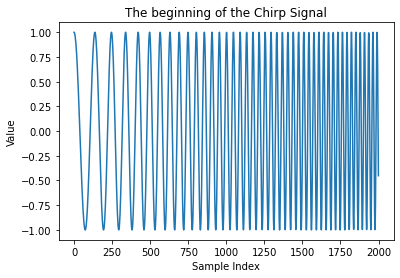

In [3]:

plt.plot(chirpsig[0:2000])
plt.title('The beginning of the Chirp Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()

### The Chirp Sound

In [4]:
Audio("chirp.wav")

### Downsampling

-  Next we downsample it by a factor of 2 without lowpass filtering.
-  We do that be keeping only every second sample 
-  The argument [::2] means: from beginning to end with index steps of 2.

In [5]:
chirpsigdownsampled=chirpsig[::2]
wav.write("chirpdownsampled.wav",samplerate//2,np.int16(chirpsigdownsampled*2**14))
Audio("chirpdownsampled.wav")

### Aliasing, Filtering

-  Observe: We can hear "artificial" frequencies, the **aliasing**
-  This shows that we need a lowpass filter to **suppress the higher frequencies** in the original which cause the aliasing
-  A very simple lowpass filter is the so-called "raised cosine" function,
-  in our example with N=8 samples or coefficients.

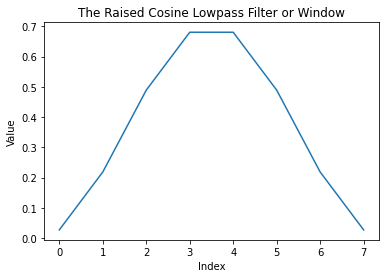

In [6]:
N=8 #length of filter
rc=(1-np.cos(2*np.pi/N*np.arange(0.5,N)))/np.sqrt(N) #raised cosine
plt.plot(rc)
plt.title('The Raised Cosine Lowpass Filter or Window')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### Frequency Response

-  Observe that this filter is **symmetric around its center**, which results in the **linear phase** property.
-  This means all frequencies have the **same signal delay**.
-  To see how much **attenuation** this filter provides, we plot its frequency response
-  We use `scipy.signal.freqz` for it

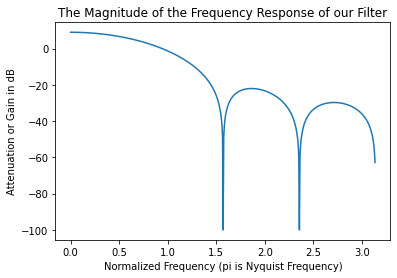

In [7]:
import scipy.signal as sp
w,H=sp.freqz(rc)
plt.plot(w, 20*np.log10(abs(H)+1e-5))
plt.title('The Magnitude of the Frequency Response of our Filter')
plt.xlabel('Normalized Frequency (pi is Nyquist Frequency)')
plt.ylabel('Attenuation or Gain in dB')
plt.show()

-  Observe: our desired stop band is above normalized frequency 1.5
-  We only obtain roughly 30 dB attenuation, which is not much for our application.
-  We can test it by applying it to our downsampling example, 
-  with the function `scipy.signal.lfilter` for the **lowpass filtering before** downsampling.

### The Lowpass Filtered and Downsampled Chirp (with Raised Cosine)

In [8]:
chirplowpass=sp.lfilter(rc,1,chirpsig)
chirplowpasssampled=chirplowpass[::2]
wav.write("chirplowpasssampled.wav",samplerate//2,np.int16(chirplowpasssampled*2**13))
Audio("chirplowpasssampled.wav")

### Improved Filter

-  Observe: The aliasing was still clearly audible
-  To better supress the aliasing, we need **more stopband attenuation**
-  We try the "Remez-exchange" algorithm `scipy.signal.remez`.
-  Now also with **more coefficients** to obtain more attenuation: N=64

### The Remez Lowpass Filter

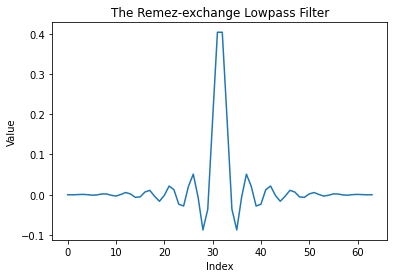

In [9]:
# Usage: remez(numtaps, bands, desired, weight=None, Hz=1)
#Passband: 0, 3000
#Stopband: 4000, 8000
#Desired band output: 1, 0
#Sampling frequency: Hz=16000
lpremez=sp.remez(64,[0, 3000, 4000, 8000],[1,0],Hz=16000)
plt.plot(lpremez)
plt.title('The Remez-exchange Lowpass Filter')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

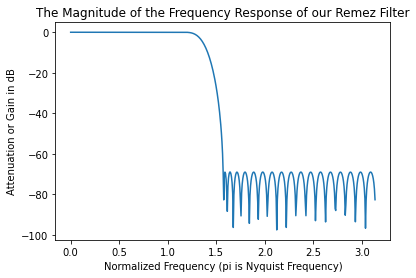

In [10]:
w,H=sp.freqz(lpremez)
plt.plot(w, 20*np.log10(abs(H)+1e-5))
plt.title('The Magnitude of the Frequency Response of our Remez Filter')
plt.xlabel('Normalized Frequency (pi is Nyquist Frequency)')
plt.ylabel('Attenuation or Gain in dB')
plt.show()

-  Observe: We now have much more stopband attenuation, about 70 dB!
-  Also the passband is much more flat, which is desirable to not change those frequency components.

-  We can now test it with our downsampling example.

In [11]:
chirplowpass=sp.lfilter(lpremez,1,chirpsig)
chirplowpasssampled=chirplowpass[::2]
wav.write("chirplowpassremezsampled.wav",samplerate//2,np.int16(chirplowpasssampled*2**13))
Audio("chirplowpassremezsampled.wav")

-  Observe: The **aliasing is now indeed completely gone!**


### Upsampling

-  For upsampling we get the reverse order
-  **First upsampling by inserting a 0 after each sample, then lowpass filtering**
-  That we need lowpass filtering also after upsampling shows the following Python example

### Upsampling

In [12]:
chirpupsampled=np.zeros(2*len(chirplowpasssampled))
chirpupsampled[::2]=chirplowpasssampled
wav.write("chirpupsampled.wav",samplerate,np.int16(chirpupsampled*2**13))
Audio("chirpupsampled.wav")

-  Observe: There is **again aliasing**, heard as a "reverse" chirp
-  Hence we need again our lowpass filter to supress the aliasing
-  Observe: both times the **filtering** happens **at the higher sampling rate** 


In [13]:
chirpupsampledlp=sp.lfilter(lpremez,1,chirpupsampled)
wav.write("chirpupsampledlp.wav",samplerate,np.int16(chirpupsampledlp*2**13))
Audio("chirpupsampledlp.wav")

## Minimum Phase Filters

-  Our better filter also became **longer**
-  If the this impulse response becomes on the order of a few Milliseconds, there will be a danger of **"pre-echos"**
-  This happens if the audio signal consists of a short attack, like from castanets
-  The filter "smears" such a pulse or attack
-  Particularly a tail before the attack can be easily picked up by the ear
-  a tail after the attack is more likely masked by the temporal masking effects of the ear
-  Hence a **non-symmetric** impulse response would be useful, 
-  with a shorter tail before the main lobe and a longer tail after it


## Minimum Phase Filters
-  This leads to **"minimum-phase"** filters.
-  In Python, we have the function `scipy.signal.minimum_phase`. 
-  It approximates the **square root** of the magnitude frequency response of a symmetric impulse response by a minimum-phase version.
-  Hence we need to input the **square of the magnitude**, 
-  which we obtain by **convolving the remez filter with itself**.

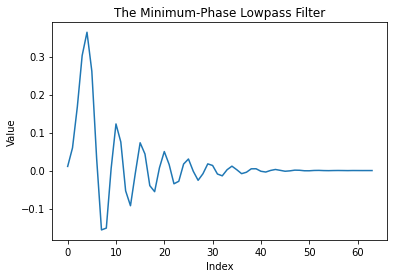

In [14]:
lp_minphase=sp.minimum_phase(sp.convolve(lpremez,lpremez))
plt.plot(lp_minphase)
plt.title('The Minimum-Phase Lowpass Filter')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

-  Observe: The main lobe is indeed now in the beginning, 
-  we have mainly a **tail after** it
-  The filter has a **signal delay** which can be estimated as the duration from the beginning to the main peak
-  Hence this filter also has **lower delay**
-  We can now compare the magnitude of the frequency response.


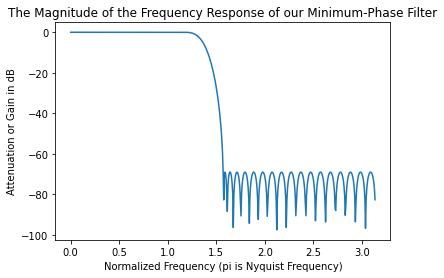

In [15]:
w,H=sp.freqz(lp_minphase)
plt.plot(w, 20*np.log10(abs(H)+1e-5))
plt.title('The Magnitude of the Frequency Response of our Minimum-Phase Filter')
plt.xlabel('Normalized Frequency (pi is Nyquist Frequency)')
plt.ylabel('Attenuation or Gain in dB')
plt.show()

-  Observe: the minimum-phase filter has indeed the **same magnitude** shape as the remez filter!

## Filter Banks

-  We now have a signal at a lower sampling rate, but half of the original **frequecy ranges gone**.
-  To avoid this, we would need **another filter** with the same bandwidth, but keeping the remaining frequencies.
-  In general, it we **downsample by a factor of N, we need N bandpass filters** to cover the original spectrum.
-  This leads to "**critical sampled filter banks**".
-  Together the filters cover the **entire original frequency range** (no lost frequencies).
-  For the synthesis we now have the **addition of all of our subbands**
-  This gives us the possibility of **cancelling all the alias** that the filters did not supress!


## Filter Bank Block Diagram

-  Left hand side: analsysis filter bank and downsampling
-  Right hand side: upsampling and Synthesis filter
-  This gives us an invertible "time/frequency" representation with the subband samples $y_k(m)$
-  $k$: subband index (frequency), $m$: donwsampled time index

<img src="filterBank.png" scale= 30% alt="Filter Bank" title="Filter Bank Block Diagram" />



Downloading...
From: https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/filterBank.png
To: /content/filterBank.png
100% 54.1k/54.1k [00:00<00:00, 9.95MB/s]


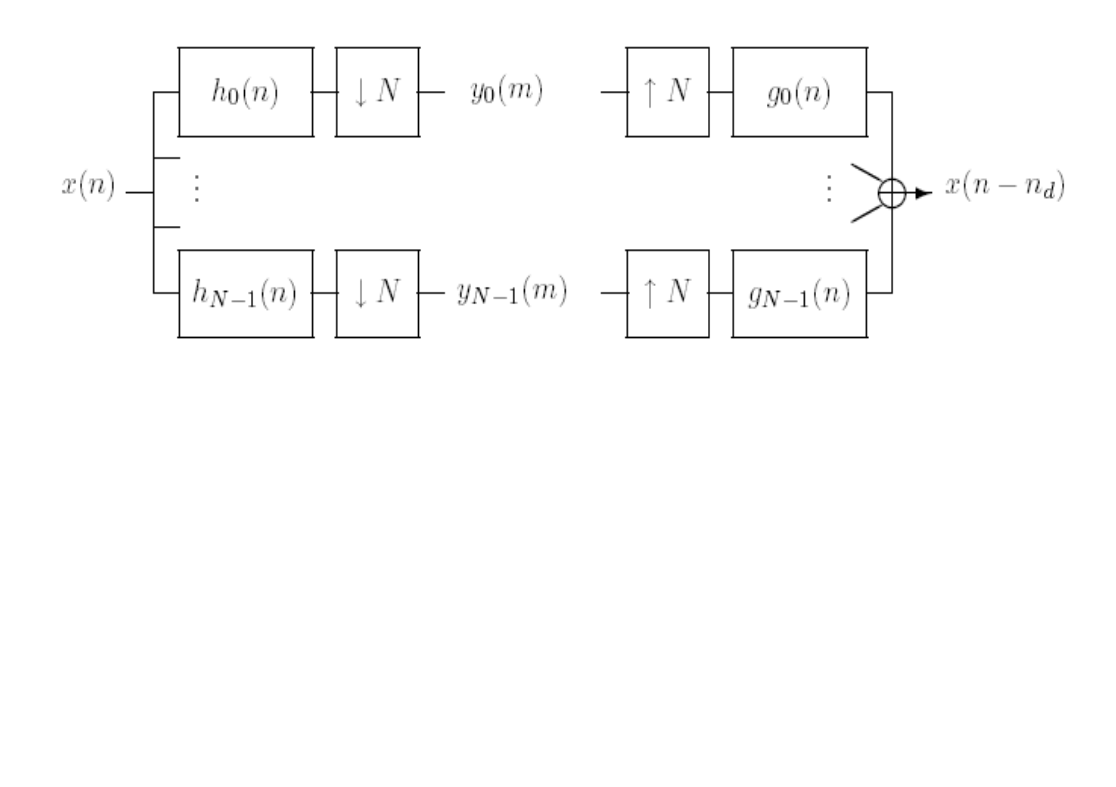

In [16]:
!gdown https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/filterBank.png
from IPython.display import Image, display
Image('filterBank.png', width=700)

### Filter Bank Applications
-  Filter banks are widely used for **audio coding**
-  In the **encoder**, the audio signal is feed into the **analysis filter bank**, 
-  the subbands are then quantized and encoded according to a **"psycho-acoustic" model**, 
-  this models the **ears sensitivities** to noise and artefacts at different frequencies
-  In this way we **minimize the bit-rate** while keeping artifacts and noise mostly inaudible.


### Filter Bank Applications
-  In effect we shape the unavoidable quantization noise such that it it **below the "masking threshold"** of the ear, hence it is inaudible.
-  This is called **"perceptual coding"**.
-  The **decoder** uses the **synthesis filter bank** to reconstruct the audio signal, with hopefully inaudible distortions
-  The signal should **sound** the same, but would **look** quite different in its waveform, or even its spectrum

## The MDCT Filter Bank

-  The **"Modified Discrete Cosine Transform"** (MDCT) filter bank is used for instance in the MPEG audio coding standards
-  It consists of **N bandpass filters**, commonly $N=1024$ or $N=128$. 
-  Each has a bandwidth of **$1/N$ th of the original frequency range**.
-  Its filters are obtained by **multiplying cosine functions by a "window function" of length $2N$**.
-  The simplest window function is the **"sine window"**.
-  It has **"Perfect Reconstruction"**
-  Meaning: If there is no change to the subband samples, the reconstructed audio signal is identical to the input, except for its **"sytem delay"** of $2N-1$ samples.


## The MDCT Filter Bank

-  Here we see the **multiplication of the cosine functions by window functions** $h(n)$ and $g(n)$ resp.,
 -  The impulse responses for the bandpasses of the "**analysis**" filter bank, which is doing the downsampling, are
$$h_k(n)=-h(n) \cdot \sqrt{\frac{2}{N}}\cos \left( \frac{\pi}{N}\left(k+\frac{1}{2}\right)\left(n \pm \frac{N}{2} +\frac{1}{2}\right)\right) $$
for the subbands $k=0,\ldots,N-1$ and the time index $n=0,\ldots, 2N-1$

 -  The impulse responses for the bandpasses of the "**synthesis**" filter bank, which is doing the upsampling, are
$$g_k(n)=g(n) \cdot \sqrt{\frac{2}{N}} \cos \left(\frac{\pi}{N}\left(k+\frac{1}{2}\right)\left(n \mp \frac{N}{2}+\frac{1}{2}\right)\right) $$

### The Sine Window

-  For the MDCT filter bank, this happens by **limiting the filter length** to $2N$
-  and by **imposing suitable conditions on the window functions** $h(n)$ and $g(n)$
-  A particularly simple and often used window which fulfills these condition is the "sine window",
$$h(n)=g(n)=\sin\left(\frac{\pi}{2N}(n+0.5)\right)$$

for $n=0,...,2N-1$.

-  This is not a great filter, it has a **quality similar to our raised cosine window**
-  but here it **cancels the aliasing!**

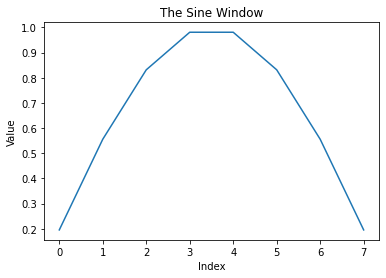

In [17]:
N=4
h=np.sin(np.pi/(2*N)*np.arange(0.5,2*N))
plt.plot(h)
plt.title('The Sine Window')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### Alternative Windows

-  An alternative Window which is used in MPEG coders is the "Kaiser Bessel Derived" (KBD) Window
-  It also fulfills the alias cancellation conditions
-  and has an optimized frequency response


### Audio Coding Applications

-  The MDCT is used to **quantize and encode the time/frequency representation** $y_k(m)$
-  The ear has different sensitivities for different frequencies and times, with **psycho-acoustic frequency and temporal maskings**
-  This also depends on the signal itself
-  The quantization step sizes are controlled by a psycho-acoustical model
-  In effect the time/frequency representation is used for **time and frequency adaptive (quantization) noise shaping**
-  In this way, ideally the quantization distortions stay inaudible, while minimizing bit-rate

### Pseudo Quadrature Mirror Filter Bank (PQMF)

-  This type of filter bank is used when very **narrow filter with high attenuation** are desired
-  Drawback: **no perfect reconstruction**
-  Aliasing cancels only between neighbouring subbands
-  Beyond these neighbouring subbands, the stopband attenutation needs to be **high enough to sufficiently supress aliasing**
-  Its window functions are obtained by **numerical optimization**, which tries to minimize the reconstructuion error while maximizing the stopband attenuation.


Downloading...
From: https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/PQMF/qmf.dat
To: /content/qmf.dat
11.5kB [00:00, 25.8MB/s]       


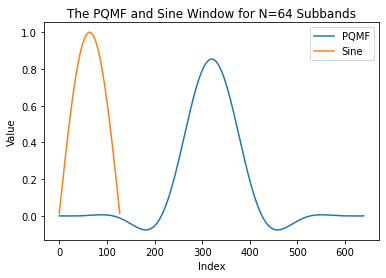

In [18]:
#!gdown 'https://github.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/blob/master/PQMF/qmf.dat'
!gdown 'https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/PQMF/qmf.dat'
#!more qmf.dat
qmfwin=np.genfromtxt('qmf.dat', usecols=range(1));
#qmfwin=np.loadtxt('https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/PQMF/qmf.dat')
#print("qmfwin=", qmfwin)
plt.plot(qmfwin)
plt.title('The PQMF and Sine Window for N=64 Subbands')
plt.xlabel('Index')
plt.ylabel('Value')
N=64
hsin=np.sin(np.pi/(2*N)*np.arange(0.5,2*N))
plt.plot(hsin)
plt.legend(('PQMF', 'Sine'))
plt.show()

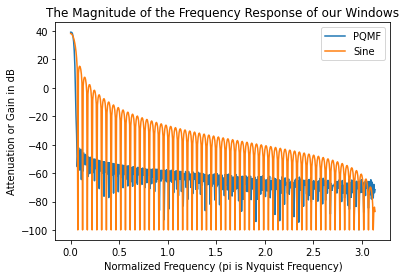

In [19]:
w,Hqmf=sp.freqz(qmfwin)
w,Hsin=sp.freqz(hsin)
plt.plot(w, 20*np.log10(abs(Hqmf)+1e-5))
plt.plot(w, 20*np.log10(abs(Hsin)+1e-5))
plt.legend(('PQMF', 'Sine'))
plt.title('The Magnitude of the Frequency Response of our Windows')
plt.xlabel('Normalized Frequency (pi is Nyquist Frequency)')
plt.ylabel('Attenuation or Gain in dB')
plt.show()

-  Observe: The sine window does not really have enough attenuation to sufficiently suppress aliasing
-  Hence we really need the **alias cancellation** property of the MDCT filter bank
-  This means we **cannot change subbands too much** (like setting neighbouring subbands to zero)
-  If we want to have more **substatial changes** over frequency we need to use the **PQMF** for its far better stopband attenuation.
-  In MPEG coders this is for instance for spacial surround encoding or parametric high frequency regeneration.


### Low Delay Filter Banks

-  Similar to minimum-phase filters, we can design low delay filter banks
-  They have a **lower system delay** than filter banks with symmetric window functions, with similar stopband attenuation 
-  or have **better stopband attenuation** at the same system delay through longer window functions
-  In the following is an example for N=1024 subbands, where the low delay filter bank has **better stopband attenuation** due to the longer window function.

### Low Delay Filter Bank Window Comparison

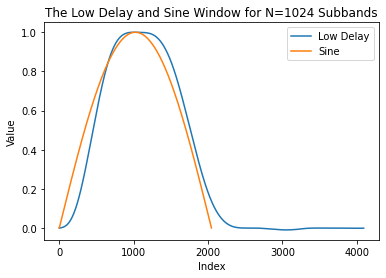

In [20]:
#ldfbwin=np.loadtxt('h4096t2047d1024bbitc.txt');
ldfbwin=np.loadtxt('https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/LowDelayFilterBank/h4096t2047d1024bbitc.txt');
plt.plot(-ldfbwin)
plt.title('The Low Delay and Sine Window for N=1024 Subbands')
plt.xlabel('Index')
plt.ylabel('Value')
N=1024
hsin=np.sin(np.pi/(2*N)*np.arange(0.5,2*N))
plt.plot(hsin)
plt.legend(('Low Delay', 'Sine'))
plt.show()

### Magnitude Frequency Response for the Low Delay Filter Bank

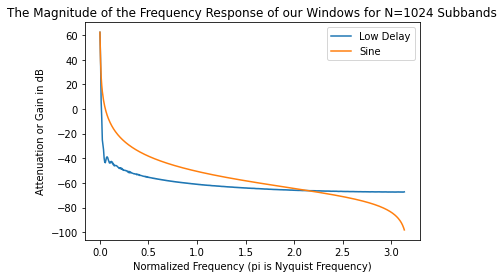

In [21]:
w,Hldfb=sp.freqz(ldfbwin)
w,Hsin=sp.freqz(hsin)
plt.plot(w, 20*np.log10(abs(Hldfb)+1e-5))
plt.plot(w, 20*np.log10(abs(Hsin)+1e-5))
plt.legend(('Low Delay', 'Sine'))
plt.title('The Magnitude of the Frequency Response of our Windows for N=1024 Subbands')
plt.xlabel('Normalized Frequency (pi is Nyquist Frequency)')
plt.ylabel('Attenuation or Gain in dB')
plt.show()

### Low Delay Filter Banks
-  Observe that we indeed obtain a much better stopband attenuation.
-  We can also use it to obtain a **lower system delay for real time communications applications** like teleconferencing.
-  It is part of the MPEG4 Enhanced Low Delay AAC audio coder (**ELD-AAC**)
-  which is part of the i-OS and Android operating systems.

### Implementation using a Neural Network Framework

-  We can use a Neural Network framwork, like "Keras", because a critically sampled filter bank is a **special case of a one layer convolutional neural network**, with N "nodes", "strides" of size N, and no non-linearity.
-  Advantage: it uses the parallel processing for fast implementation, even without a fast implementation like using an FFT.
-  This makes a fast implementation simpler.

### Github Repository for Filter Bank Implementation 

-  Implementation using a Fast Fourier Transform:
-  `https://github.com/TUIlmenauAMS/`<br>
`FilterBanks_FastPythonImplementation`
-  Implementation using the Keras Neural Nework Python library. 
-  This has the advantage that it works for more generic filter banks, 
-  and it uses a GPU for fast implementation
-  `https://github.com/TUIlmenauAMS/`<br>
`FilterBanks_PythonKerasNeuralNetworkImplemention`

### De-Nosing example

-  We can use the ability of filter banks for **noise shaping** for a de-nosing example
-  If a subband at a certain time **mostly contains noise** (is below a threshold), its signal is **set to zero**.
-  If the signal is **above a threshold, it remains unchanged**
-  This assumes that we **estimated** the strength of the noise before.
-  In our example we take the **chirp signal with added noise** (hence we know the noise in this case)
-  We choose uniformly distributed noise, which could result from quantization.



### MDCT Spectrogram of our Clean Chirp Signal

Downloading...
From: https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/MDCT/keras_MDCTanalysis.py
To: /content/keras_MDCTanalysis.py
3.94kB [00:00, 3.15MB/s]       
Initializing MDCT analysis weights


Text(0.5, 1.0, 'The MDCT Spectrogram of the Chirp Signal')

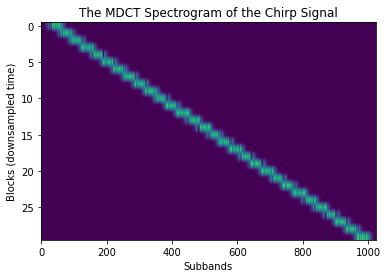

In [22]:
#!pip install pyaudio
#!gdown https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/MDCT/sound.py
!gdown https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/MDCT/keras_MDCTanalysis.py
from keras_MDCTanalysis import *
N=1024 #Number of filters, stride
filtlen=2048 #Length of filter impulse response
modelana = generate_model_ana(N,filtlen)     # Compile an neural net analysis filter bank
Y=keras_MDCT_ana(chirpsig,modelana)
plt.imshow(abs(Y),aspect='auto')
plt.xlabel('Subbands')
plt.ylabel('Blocks (downsampled time)')
plt.title('The MDCT Spectrogram of the Chirp Signal')

### Noisy Chirp Test Example
-  We now add white noise to our chirp signal for testing

In [23]:
chirpsignoise=chirpsig+ (np.random.rand(len(chirpsig))-0.5)*1.0
wav.write("chirpsignoise.wav",samplerate//2,np.int16(chirpsignoise*2**14))
Audio("chirpsignoise.wav")

### MDCT Spectrogram of the Noisy Chirp

Text(0.5, 1.0, 'The MDCT Spectrogram of the Chirp with Noise')

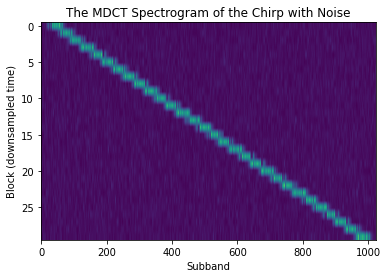

In [24]:
Y=keras_MDCT_ana(chirpsignoise,modelana)
plt.imshow(abs(Y),aspect='auto')
plt.xlabel('Subband')
plt.ylabel('Block (downsampled time)')
plt.title('The MDCT Spectrogram of the Chirp with Noise')

-  Observe: the noise is visible as a **"snow" like pattern**.

### Noise Estimation
-  To **estimate the level of the noise** we plot the magnitude spectrum of block number 15
-  Observe: the noise is below magnitude 1, the chirp signal is above.
-  We can use this threshold to distinguish between noise and signal.

Text(0.5, 1.0, 'Magnitude Spectrum of Block 15')

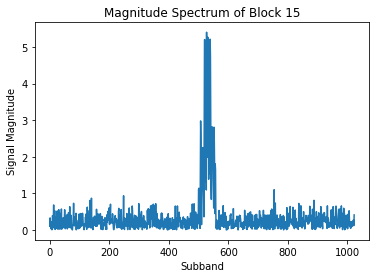

In [25]:
plt.plot(abs(Y[15,:]))
plt.xlabel('Subband')
plt.ylabel('Signal Magnitude')
plt.title('Magnitude Spectrum of Block 15')

### Signal Separation
-  Now we can build a **"binary mask"** for our MDCT representation
-  With it, we **multiply** time/frequency bin which we classify as noise **with 0, hence discarded**
-  Time/frequency bins which we classify as **signal are kept by multiplying it with 1**
-  Our binary mask has the same size as our MDCT representation, and has the **1's and 0's at the corresponing positons**
-  Such masks are also used to separate signals in **audio source separation**
-  We separate the signals by **elementwise multiplication**
-  In our case we **separate the signal from the noise**

### The Binary Mask

Text(0.5, 1.0, 'The Binary mask for our Chirp Signal (Yellow is 1)')

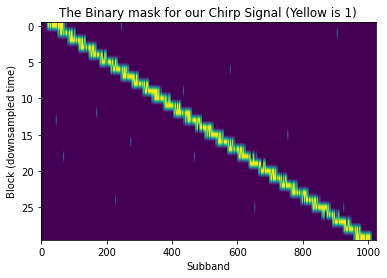

In [26]:
# Create the binary mask:
binarymask=abs(Y)>1.0
plt.imshow(binarymask,aspect='auto')
plt.xlabel('Subband')
plt.ylabel('Block (downsampled time)')
plt.title('The Binary mask for our Chirp Signal (Yellow is 1)')

### The MDCT Spectrogram after Applying the Mask

Text(0.5, 1.0, 'The De-noised MDCT Spectrogram after Masking')

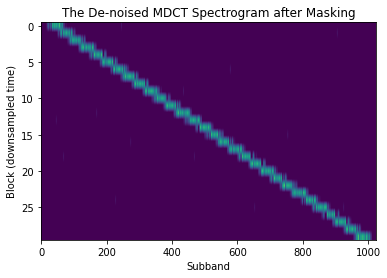

In [27]:
# Elementwise multiplication with the binary mask:
Ydenoise=Y*binarymask
plt.imshow(abs(Ydenoise),aspect='auto')
plt.xlabel('Subband')
plt.ylabel('Block (downsampled time)')
plt.title('The De-noised MDCT Spectrogram after Masking')

-  Observe: the snow like pattern disappeared

### The MDCT Synthesis Filter Bank
-  To return to the time domain, we now apply the MDCT synthesis filter bank to our de-noised MDCT representation

In [28]:
!gdown https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/MDCT/keras_MDCTsynthesis.py
from keras_MDCTsynthesis import *
modelsyn = generate_model_syn(N,filtlen)
#MDCT Synthesis:
xrek= keras_MDCT_syn(Ydenoise,modelsyn)
wav.write("xrekMDCTdenoised.wav",samplerate//2,np.int16(xrek*2**14))
Audio("xrekMDCTdenoised.wav")

Downloading...
From: https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/MDCT/keras_MDCTsynthesis.py
To: /content/keras_MDCTsynthesis.py
4.16kB [00:00, 12.0MB/s]       
Initializing MDCT synthesis weights
subbands.shape= (1, 30, 1, 1024)
xrek.shape= (1, 31744, 1, 1)


-  Observe: the noise is almost completely gone, except for some musical noise
-  It results from non-cancelled aliasing from switching off neighbouring subbands
-  And from some time/frequency bins outside the chirp turned falsely on.

### PQMF De-Noising
-  To reduce the "musical" noise from MDCT de-noising, we can apply the sharper filters of an PQMF

Downloading...
From: https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/PQMF/keras_PQMFanalysis.py
To: /content/keras_PQMFanalysis.py
4.04kB [00:00, 3.35MB/s]       
Initializing MDCT weights
qmfwin.shape= (640,)


Text(0.5, 1.0, 'The PQMF Spectrogram of the Chirp Signal')

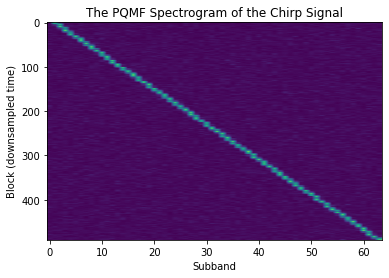

In [29]:
!gdown https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/PQMF/keras_PQMFanalysis.py
from keras_PQMFanalysis import *
N=64 #1024 #Number of filters
filtlen=640 #8192 #Length of filter impulse response
modelana = generate_model_ana(N,filtlen)    # Compile an neural net analysis filter bank
Y=keras_PQMF_ana(chirpsignoise,modelana)
plt.imshow(abs(Y),aspect='auto')
plt.xlabel('Subband')
plt.ylabel('Block (downsampled time)')
plt.title('The PQMF Spectrogram of the Chirp Signal')

### Noise Estimation for PQMF
-  To **estimate the level of the noise** we plot the magnitude spectrum of block number 15
-  Observe: the noise is below magnitude 1, the chirp signal is above.
-  We can use this threshold to distinguish between noise and signal.

Text(0.5, 1.0, 'Magnitude Spectrum of Block 15')

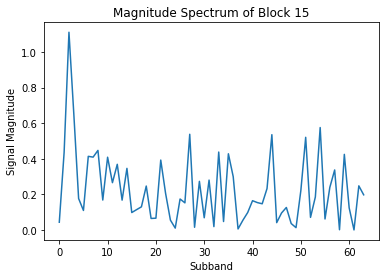

In [30]:
plt.plot(abs(Y[15,:]))
plt.xlabel('Subband')
plt.ylabel('Signal Magnitude')
plt.title('Magnitude Spectrum of Block 15')

Text(0.5, 1.0, 'The De-noised PQMF Spectrogram after Masking')

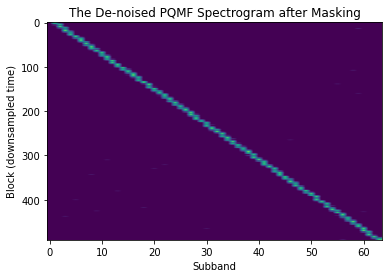

In [31]:
# Create the binary mask:
binarymask=abs(Y)>1.0
Ydenoise=Y*binarymask
plt.imshow(abs(Ydenoise),aspect='auto')
plt.xlabel('Subband')
plt.ylabel('Block (downsampled time)')
plt.title('The De-noised PQMF Spectrogram after Masking')


In [32]:
!gdown https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/PQMF/keras_PQMFsynthesis.py
from keras_PQMFsynthesis import *
modelsyn = generate_model_syn(N,filtlen)
#MDCT Synthesis:
xrek= keras_PQMF_syn(Ydenoise,modelsyn)
wav.write("xrekPQMFdenoised.wav",samplerate//2,np.int16(xrek*2**14))
Audio("xrekPQMFdenoised.wav")

Downloading...
From: https://raw.githubusercontent.com/TUIlmenauAMS/FilterBanks_PythonKerasNeuralNetworkImplemention/master/PQMF/keras_PQMFsynthesis.py
To: /content/keras_PQMFsynthesis.py
4.33kB [00:00, 3.45MB/s]       
Initializing MDCT weights
qmfwin.shape= (640,)
subbands.shape= (1, 491, 1, 64)
xrek.shape= (1, 32000, 1, 1)


## Predictive Filters
-  Filters can also be used to **predict the next sample** of an audio signal 
-  In an **encoder**, the predicted sample is **subtracted** from the true sample, resulting in the **prediction error**, which is encoded and transmitted to the decoder
-  in the **decoder** does the same prediction, which is **added back** to the **received prediction error**


## Predictive Filters
-  **Smooth signals**, like sinusoids, are **easy to predict**
-  **Noise** like signals, like quantization noise, are **difficult to predict**
-  This means: the **predictor output** contains mostly the **predictable** part
-  Hence the predictor output can be used for **de-nosing**

## Adaptive Predictive Filter

-  Adaptive filters are **(continuously) adapted** to the  audio signal to optimize prediction performance
-  A well know example is the **"Least Mean Squares"** (LMS) filter
 -  It **minimizes the mean squared prediction error** over time
-  The "Normalized" LMS (NLMS) filter normalizes its update steps to the signal power, and hence becomes less dependend on the signal amplitude.
-  In Python it is implemented in `adaptfilt.lms` and `adaptfilt.nlms`.

### Python Example for (N)LMS De-Nosing

-  First we generate a noisy chirp signal for testing

In [33]:
chirpsignoise=chirpsig+ (np.random.rand(len(chirpsig))-0.5)*1.0
wav.write("chirpsignoise.wav",samplerate//2,np.int16(chirpsignoise*2**14))
Audio("chirpsignoise.wav")

-  Next we apply an NLMS filter for de-noising,

In [34]:
!pip install padasip > Null
import padasip as pa
#predictor for the chirp signal, signal to predict is 1 sample ahead:
#http://matousc89.github.io/padasip/sources/preprocess/input_from_history.html
x=pa.input_from_history(chirpsignoise[:-1],20) #turn input into Toeplitz matrix
f = pa.filters.FilterNLMS(n=20, mu=0.1, w="random")
d=chirpsignoise[20:]
print(chirpsignoise.shape)
print("x.shape=", (x.shape))
print("len(d)=", len(d), "len(x)=",len(x))
predicted, error, lastweights = f.run(d, x)
print("lastweights=", lastweights)
wav.write("chirppredicted.wav",samplerate//2,np.int16(predicted*2**14))
Audio("chirppredicted.wav")

(32000,)
x.shape= (31980, 20)
len(d)= 31980 len(x)= 31980
lastweights= [[-0.96589515 -0.92046675  0.6704104  ... -0.29306861  0.96359961
  -0.05766332]
 [-0.96478069 -0.91976512  0.67115772 ... -0.29202582  0.96448135
  -0.05744538]
 [-0.95976701 -0.914425    0.67516155 ... -0.28572513  0.96603868
  -0.05480304]
 ...
 [-0.05807522  0.03751349 -0.05196224 ... -0.11762557  0.11868167
  -0.13398944]
 [-0.05649281  0.03593444 -0.05064969 ... -0.11885648  0.11957992
  -0.13465853]
 [-0.05573785  0.0353069  -0.0498483  ... -0.11928594  0.11989982
  -0.13530127]]


-  Observe: we hear **less noise and noise shaping**, 
-  but the de-noising is **less effective than with the filter bank**
-  but due to the predictor structure, it has **no system delay**
-  This make it suitable for **real time speech communications**


## Predictive Lossless Coding
-  Predictors can be easily applied to **lossless coding**, 
-  if the input of the encoder is integer valued audio samples, the predicted value can be **rounded to be integer valued** to produce an integer valued prediction error
-  This leads to a **reduced bit-rate**
-  The decoder simply **adds the same rounded predicted value back** to obtain the reconstructed **original integer audio samples**
-  This principle is used for instance in **MPEG-4 ALS lossless coding**

## Lossless Coding with Integer-to-Integer MDCT (IntMDCT)
-  In general the MDCT filter bank produces **float valued** samples in its subbands, 
-  even if the input was integer valued, like for instance the usual 16, 24, or 32 bit audio samples
-  For lossless coding, **integer valued  subband values are needed**, which can be reconstructed to the original audio samples
-  If we just round the samples from an MDCT to the nearest integers, it is not reconstructing the exact same integers
-  The **IntMDCT** solves this problem: its analysis filter bank produces **integer subband values**
-  Its synthesis filter bank **reconstructs the exact original integer values**


### The Block Diagram of (Part of) the Encoder IntMDCT for Stereo



Downloading...
From: https://raw.githubusercontent.com/TUIlmenauAMS/Python-Audio-Coder/master/MultiDimLifting.jpg
To: /content/MultiDimLifting.jpg
100% 23.6k/23.6k [00:00<00:00, 21.7MB/s]


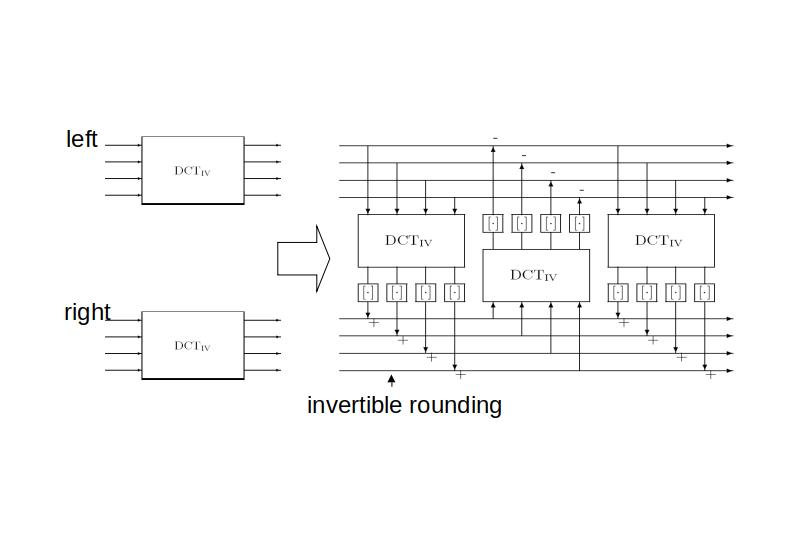

In [35]:
!gdown https://raw.githubusercontent.com/TUIlmenauAMS/Python-Audio-Coder/master/MultiDimLifting.jpg
from IPython.display import Image, display
Image('MultiDimLifting.jpg', width=800)

### The Block Diagram of the IntMDCT

-  The **decoder** IntMDCT has the same structure, except it is **mirrored** left to right, and **subtractions and additions are switched**.
-  Observe: the IntMDCT uses the **same principle** as lossless predictive coding: 
-  on the encoding side, **rounded values are subtracted (or added)**, 
-  on the decoding side, the **same rounded values are added (or subtracted)** for exact reconstruction.

## The Integer-to-Integer MDCT (IntMDCT)

-  It can be combined with lossy perceptual MDCT based audio coders, like the MPEG-AAC coder
-  In this way we can create a scalable extension layer for lossless coding, 
-  There the decoder can choose if it wants to decode the low bitrate lossy version or to include the lossless layer.
-  It is used in **MPEG-4 SLS lossless audio coding**, also known as **HD-AAC**.

# Conclusions
-  We saw: digital filters can be seen as a running weightes average of previous samples
-  Filter banks allow us to donwsample without loosing bandwidth and with perfect reconstruction
-  We can use them for coding, noise shaping, and de-noising
-  Minimum-Phase filter can reduce the signal delay while keeping the same or similar magnitude response and stopband attenuation
-  Similar, Low Delay filter banks can reduce the system delay, for realy time coding applications, like teleconferencing 


# Conclusions
-  Predictive filters can be used for low delay coding and also noise shaping and de-noising
-  They can also be easily used for lossless coding
-  The IntMDCT produces integer valued subband signals
-  It can be used for lossless coding and lossless enhancement layers for perceptual audio coders.
-  Slides available at:
https://www.tu-ilmenau.de/en/applied-media-systems-group/publications/